In [32]:
# Analysis on cooling effects from water bodies in Copenhagen 

# changes in Land Surface Temperature (LST) is used to detect the cooling effects

#lst_case.tif: The study area extent is created through a Union and a 
#Dissolve of the lakes_and_sea dataset and the official extents of 
#the two municipalities; the City of Copenhagen and Frederiksberg. 
#The calculated LST result is converted to EPSG:25832 with Project Raster 
#and cut to the case study extent with Extract by Mask and used as template 
#for further raster processing (Environment settings for extent, cell size, 
#mask, and snap raster). 

#lakes.shp and seas.shp: The lakes (or seas respectively) are selected in 
#the lakes_and_sea dataset (Select By Attributes) and extracted to their 
#own layer (Copy Features).  

#lakes_case.tif and seas_case.tif: The lakes (or seas respectively) are 
#converted into a raster (Raster to Polygon) with the same parameters as 
#the LST for the case study area.  

#euc_lake_distV2.tif and euc_seas_distV2.tif: Euclidean Distance is used 
#to calculate the distance to the nearest lake (or sea respectively) for 
#each raster cell following the parameters as the LST for the case study area.  

#lakes_source_near.tif and seas_source_near.tif: Euclidean Allocation is 
#used to provide the id in each raster cell of the nearest lake (or nearest 
#sea polygon respectively) following the parameters as the LST for the 
#case study area.


In [ ]:
#pip install statsmodels
#pip install pandas matplotlib
#pip install numpy
#pip install scipy
#pip install geopandas
#!pip install matplotlib-scalebar
#pip...

In [1]:
# SETUP
import pandas as pd
import rasterio
from rasterio.mask import mask
import rasterio.features
from rasterio.transform import array_bounds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.lines as mlines
import geopandas as gpd
import contextily as cx # for getting background maps
from shapely.geometry import mapping
from shapely.geometry import box # for getting bbox
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from shapely.ops import voronoi_diagram
import statsmodels.api as sm  # Import statsmodels for regression
from scipy import stats  # For regression analysis
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from libpysal.weights import DistanceBand
import seaborn as sns



In [2]:
# SETUP
# import rasters
lst = rasterio.open('landsat20200601/lst_20200601_final.tif').read(1).astype('float64') # Land surface temperature in study area Copenhagen
lakes_case = rasterio.open('analysis_input_data/lakes_case.tif').read(1).astype('float64') # lakes=1 
lake_dist = rasterio.open('analysis_input_data/lakes_euc_dist.tif').read(1).astype('float64') # distances in metres to nearest lake
lakes_source_near = rasterio.open('analysis_input_data/lakes_source_near.tif').read(1).astype('float64') # id of nearest lake
seas_case = rasterio.open('analysis_input_data/seas_case.tif').read(1).astype('float64') # sea=1
sea_dist = rasterio.open('analysis_input_data/seas_euc_dist.tif').read(1).astype('float64') # distances in metres to sea
seas_source_near = rasterio.open('analysis_input_data/seas_source_near.tif').read(1).astype('float64') # id of nearest sea polygon

imp = rasterio.open('imp2018/imp2018.tif').read(1).astype('float64') # id of nearest sea polygon
mndwi = rasterio.open('landsat20200601/mndwi_20200601.tif').read(1).astype('float64') # id of nearest sea polygon
ndvi = rasterio.open('landsat20200601/ndvi_20200601.tif').read(1).astype('float64') # id of nearest sea polygon


In [3]:
# SETUP
# Read the shapefile
lakes = gpd.read_file("analysis_input_data/lakes_casestudy.shp") # all lake polygons with attribute data
#lakes = gpd.read_file("lakes.shp") # all lake polygons with attribute data
print(lakes.head()) # Show the first few rows of the dataframe

# Read the shapefile
seas = gpd.read_file("analysis_input_data/seas.shp") # all sea polygons with attribute data
print(seas.head()) # Show the first few rows of the dataframe

   fid_    id objekt_typ        kommune    area_ha  perimeter       details  \
0     0  1138         Sø  Frederiksberg   0.096052         73   obs cooling   
1     0   240         Sø      København  14.834820       2288  close to sea   
2     0  1140         Sø      København   3.693557        918   obs cooling   
3     0   517         Sø      København   6.313699        625   obs cooling   
4     0   516         Sø      København   0.804220        389   obs cooling   

   obs_dist    obs_lst    est_dist    est_lst   cool_trend  herbCross  \
0       315  27.794376  171.010603  25.908302     positive        NaN   
1       165  28.605614  242.849081  28.548786  seaPositive        NaN   
2       255  28.224209  223.030366  26.633807     positive        NaN   
3        75  24.103312  230.672440  26.776500     positive        NaN   
4       135  26.649478  201.300379  27.251340     positive        NaN   

   herbCoolCr  woodCoolCr  vegOverlap            vegExplain  \
0         NaN         N

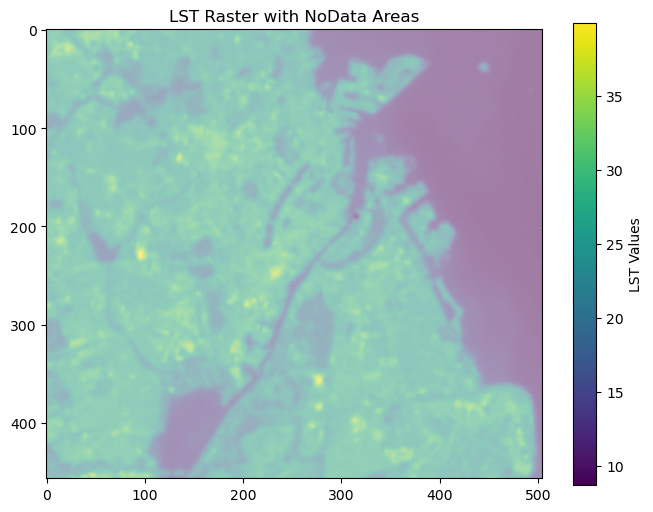

In [4]:
# SETUP
# Set NoData in LST
min_value = np.nanmin(lst)  # Find minimum value (excluding NaNs)
# Set min value as nodata
lst[lst == min_value] = np.nan
#src.nodata = min_value  # Update nodata in metadata

# Create nodata mask
nodata_mask = np.isnan(lst)

# Plot raster and nodata areas
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(lst, cmap="viridis", interpolation="none")
plt.colorbar(cax, label="LST Values")

# Overlay nodata areas
ax.imshow(nodata_mask, cmap="Reds", alpha=0.5)  # Red overlay for nodata areas
ax.set_title("LST Raster with NoData Areas")
plt.show()

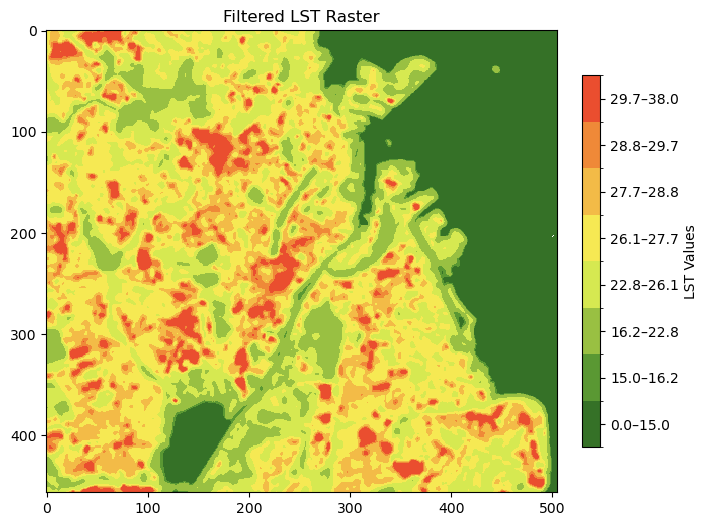

In [5]:
# LST FOR VISUALISATION
# Set NoData in LST
min_value = np.nanmin(lst)  # Find minimum value (excluding NaNs)
# Set min value as nodata
lst[lst == min_value] = np.nan
#src.nodata = min_value  # Update nodata in metadata

# Create nodata mask
nodata_mask = np.isnan(lst)

# Define class edges and colors
lst_new_colorbins_lst = [0, 15.0, 16.2, 22.8, 26.1, 27.7, 28.8, 29.7, 38.0]
lst_new_colors_lst = ["#357127", "#5A9833", "#99C042", "#D6E951", "#F6E953", "#F3BB47", "#EF8938", "#EA4E2F"]
lst_new_classes_lst = np.digitize(lst, lst_new_colorbins_lst, right=False) - 1
lst_new_classes_lst[np.isnan(lst)] = -1  # mark NoData as -1
lst_plot_new_lst = np.ma.masked_where(lst_new_classes_lst < 0, lst_new_classes_lst)
# Create colormap
lst_new_cmap_lst = ListedColormap(lst_new_colors_lst)
norm_lst = BoundaryNorm(lst_new_colorbins_lst, lst_new_cmap_lst.N)

# Plot the filtered raster
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(
    lst,
    cmap=lst_new_cmap_lst,
    norm=norm_lst,
    interpolation="none"
)

cbar = fig.colorbar(cax, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("LST Values")
cbar.set_ticks([(lst_new_colorbins_lst[i]+lst_new_colorbins_lst[i+1])/2 for i in range(len(lst_new_colorbins_lst)-1)])
cbar.set_ticklabels([f"{lst_new_colorbins_lst[i]:.1f}–{lst_new_colorbins_lst[i+1]:.1f}" for i in range(len(lst_new_colorbins_lst)-1)])

ax.set_title("Filtered LST Raster")
plt.show()

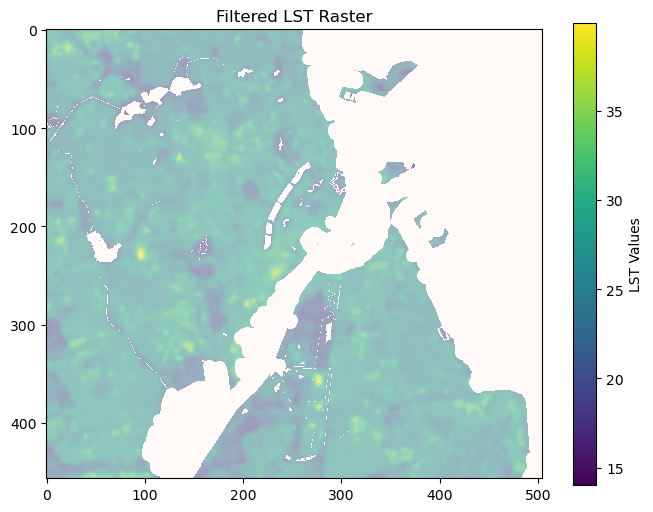

mean of LST is  22.561719366478908
min of LST is  8.723279772672603
max of LST is  39.937144630998084
mean of LST is  26.629893338362066
min of LST is  14.027825493696145
max of LST is  39.937144630998084


In [6]:
# Statistics of LST heatwave dataset 
stat_lst_mask = ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195) & (lakes_case != 1)
stat_lst_raster = lst.copy()
stat_lst_raster[~stat_lst_mask] = np.nan  # set unselected pixels to NaN
#stat_lst = lst[stat_lst_mask]

# Plot the filtered raster
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(stat_lst_raster, cmap="viridis", interpolation="none")
plt.colorbar(cax, label="LST Values")

# Optional: overlay NoData areas in red
ax.imshow(np.isnan(stat_lst_mask), cmap="Reds", alpha=0.5)

ax.set_title("Filtered LST Raster")
plt.show()

print("mean of LST is ", np.nanmean(lst))
print("min of LST is ", np.nanmin(lst))
print("max of LST is ", np.nanmax(lst))
print("mean of LST is ", np.nanmean(stat_lst_raster))
print("min of LST is ", np.nanmin(stat_lst_raster))
print("max of LST is ", np.nanmax(stat_lst_raster))


In [7]:
# SETUP
# Apply NoData mask from lst to all the other rasters
lake_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_source_near[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_case[nodata_mask] = np.nan  # Set NoData where lst had NoData
sea_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_source_near[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_case[nodata_mask] = np.nan  # Set NoData where lst had NoData
imp[nodata_mask] = np.nan  # Set NoData where lst had NoData
mndwi[nodata_mask] = np.nan  # Set NoData where lst had NoData
ndvi[nodata_mask] = np.nan  # Set NoData where lst had NoData



In [8]:
# CALCULATE OBSERVED TURNING DISTANCES AND ADD AS COLUMN 
### Analysis 6B: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = lakes['id']

# Create a new column filled with NaNs
lakes['obs_zone'] = np.nan

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index > 0 and not np.isnan(turn_mean_lst_values) and turn_mean_lst_values != -9999:
        turning_point_distance = bin_labels[turning_point_index]
        lakes.loc[lakes['id'] == lake_id, 'obs_zone'] = turning_point_distance
        # add turn_mean_lst_values to lakes_positive['obs_cooldif']

#print(lakes['obs_zone'].unique())
#print(lakes[lakes['obs_zone'].notna()]['obs_zone'].unique())


In [9]:
# BUFFER LAKE POLYGONS BASED ON OBSERVED DISTANCES
# Subset lakes where obs_dist > 0
lakes_positive = lakes[lakes['obs_zone'] > 0].copy() #obs_dist
lakes_positive = lakes_positive[lakes_positive['details'] == "obs cooling"].copy()

# Create a new geometry column with buffered polygons
lakes_positive['geometry_buffered_obs'] = lakes_positive.geometry.buffer(lakes_positive['obs_zone']) #obs_dist

In [10]:
# CALCULATE OBSERVED TURNING POINT EFFECTS AND ADD AS COLUMN 
### Analysis 6B: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = lakes_positive['id']

# Create a new column filled with NaNs
lakes_positive['obs_cooldif'] = np.nan

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]
    #print(delta_lst)

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index > 0 and not np.isnan(turn_mean_lst_values):
        lakes_positive.loc[lakes_positive['id'] == lake_id, 'obs_cooldif'] = turn_mean_lst_values
        # add turn_mean_lst_values to lakes_positive['obs_cooldif']

#print(lakes_positive['obs_cooldif'].unique())
#print(lakes_positive[lakes_positive['obs_cooldif'].notna()]['obs_cooldif'].unique())

# only include polygons with observed cooling effects: 
lakes_positive = lakes_positive[lakes_positive['obs_cooldif'].notna()].copy()



mean of LST is  25.026903801212246
min of LST is  14.754195023944431
max of LST is  39.046681550725125


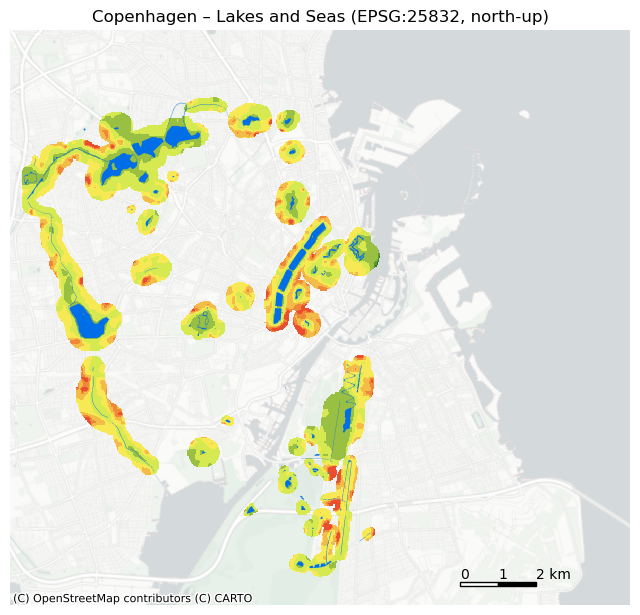

In [11]:
# MAP LST IN OBSERVED TURNING POINT DISTANCES 
from rasterio.transform import array_bounds

# Calculate and map LST in observed turning point zones
with rasterio.open('landsat20200601/lst_20200601_final.tif') as src:
    lst_transform = src.transform

# Make mask (True outside lakes, False inside)
mask_arr = rasterio.features.geometry_mask(
    lakes_positive['geometry_buffered_obs'].apply(mapping),  # use buffered geometry
    invert=True,                             # keep values inside lakes
    transform=lst_transform,
    out_shape=lst.shape
)

# Apply mask
lst_masked = np.where(mask_arr, lst, np.nan)

print("mean of LST is ", np.nanmean(lst_masked))
print("min of LST is ", np.nanmin(lst_masked))
print("max of LST is ", np.nanmax(lst_masked))

# Define class edges and colors
lst_colorbins = [0, 15.0, 16.2, 22.8, 26.1, 27.7, 28.8, 29.7, 38.0]
lst_colors = ["#357127", "#5A9833", "#99C042", "#D6E951", "#F6E953", "#F3BB47", "#EF8938", "#EA4E2F"]

# Classify LST
lst_classes = np.digitize(lst_masked, lst_colorbins, right=False) - 1
lst_classes[np.isnan(lst_masked)] = -1  # mark NoData as -1

# Create masked array: NoData (-1) becomes invisible
lst_plot_masked = np.ma.masked_where(lst_classes < 0, lst_classes)

# Create colormap
lst_cmap = ListedColormap(lst_colors)

# Map over all seas and lakes 
lake_color = "#006EE6"

# Original Copenhagen bbox in WGS84
bbox_wgs84 = box(12.45, 55.61, 12.70, 55.74)

# Project to EPSG:25832
gdf = gpd.GeoDataFrame(geometry=[bbox_wgs84], crs="EPSG:4326").to_crs(epsg=25832)

minx, miny, maxx, maxy = gdf.total_bounds

# Scale bar position (bottom-right)
x_start = maxx - 2000*2 - 500  # shift from edge, in meters
y_start = miny + 500           # shift from bottom, in meters

bar_length = 1000  # 1 km per segment

fig, ax = plt.subplots(figsize=(8, 8))

# Set map extent
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# --- Basemap: Stamen TonerLite, semi-transparent ---
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:25832",  # important: reproject tiles to match axes
    alpha=1.0           # dim basemap, polygons stay vivid
)

# prepare for LST
height, width = lst_plot_masked.shape
xmin2, ymin2, xmax2, ymax2 = array_bounds(height, width, lst_transform)
extent = (xmin2, xmax2, ymin2, ymax2)

# --- LST
cax = ax.imshow(
    lst_plot_masked,
    cmap=lst_cmap,
    interpolation="none",
    extent=extent,
    origin="upper",
    zorder=1
)

# --- Lakes (full color, north-up) ---
lakes[lakes['details'] == "obs cooling"].plot(
    ax=ax,
    facecolor=lake_color,
    edgecolor="none",
    alpha=1.0,
    zorder=2
    )

# --- Draw striped scale bar: 2 segments (1 km white + 1 km black) ---
scale_colors = ["white", "black"]
for i, color in enumerate(scale_colors):
    rect = patches.Rectangle(
        (x_start + i*bar_length, y_start),  # lower-left corner
        bar_length,                          # width
        100,                                 # height of bar (meters)
        facecolor=color,
        edgecolor="black"
    )
    ax.add_patch(rect)

# Add text labels without repeating "km"
ax.text(x_start, y_start + 120, "0", color="black", fontsize=10, va='bottom')
ax.text(x_start + bar_length, y_start + 120, "1", color="black", fontsize=10, va='bottom')
ax.text(x_start + 2*bar_length, y_start + 120, "2 km", color="black", fontsize=10, va='bottom')

# Optional: remove axes
ax.set_axis_off()
plt.title("Copenhagen – Lakes and Seas (EPSG:25832, north-up)")
plt.show()

fig.savefig(
    "map_obs_lst_zones20200601.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)

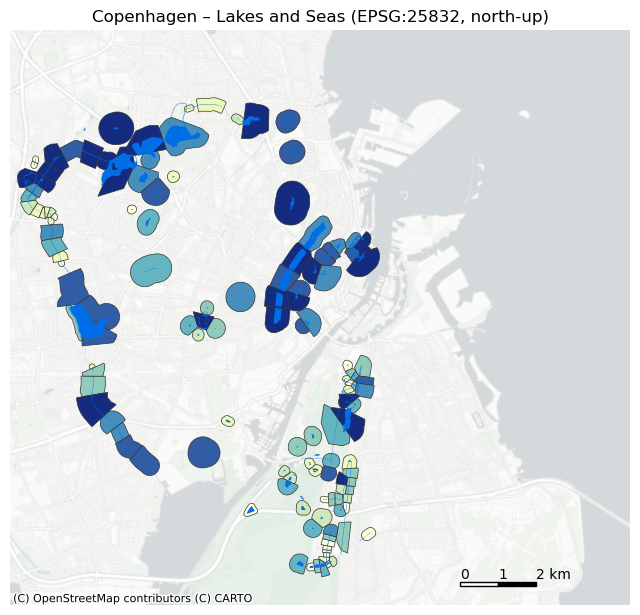

In [12]:
# MAP OBSERVED COOLING EFFECTS
# Create a new geometry column with buffered polygons
#lakes_positive['geometry_buffered_obs'] = lakes_positive.geometry.buffer(lakes_positive['obs_zone']) #obs_dist
centroids = lakes_positive.geometry.centroid

# Create Voronoi diagram with envelope = union of buffered polygons
vor_obs = voronoi_diagram(
    MultiPoint(list(centroids)),
    envelope=lakes_positive['geometry_buffered_obs'].union_all()  # use union_all() instead of unary_union
)

# Convert Voronoi polygons to a GeoDataFrame
vor_obs_gdf = gpd.GeoDataFrame(geometry=list(vor_obs.geoms), crs=lakes_positive.crs)

# Clip each buffer to its Voronoi polygon
buffers_cut = []
# Loop over each lake buffer
for i, buffer_geom in enumerate(lakes_positive['geometry_buffered_obs']):
    centroid = lakes_positive.geometry.iloc[i].centroid  # lake centroid
    # Find the Voronoi polygon that contains this centroid
    matching_cell = vor_obs_gdf[vor_obs_gdf.geometry.contains(centroid)]
    if not matching_cell.empty:
        buffers_cut.append(buffer_geom.intersection(matching_cell.geometry.iloc[0]))
    else:
        # fallback if something went wrong
        buffers_cut.append(buffer_geom)
        
# Create a GeoDataFrame of clipped buffers
vor_obs_gdf_clipped = gpd.GeoDataFrame({
    'geometry': buffers_cut,
    'id': lakes_positive['id'],
    'obs_cooldif': lakes_positive['obs_cooldif']
}, crs=lakes_positive.crs)

# Remove empty geometries (just in case)
vor_obs_gdf_clipped = vor_obs_gdf_clipped[~vor_obs_gdf_clipped.is_empty].reset_index(drop=True)

# Number of classes
#n_classes_obs_cool = 8
# Compute quantiles
#bufferbins_obs_cool = vor_obs_gdf_clipped['obs_cooldif'].quantile(q=np.linspace(0, 1, n_classes_obs_cool + 1)).values
bufferbins_obs_cool = np.array([
    0.00000, #min is 0.00927 in 2018 observed
    0.33304,
    0.86265,
    1.31722,
    2.09591,
    2.91911,
    3.78772,
    4.69376,
   12.58803 # max is 7.74997933037255 with np.max(lakes_positive['obs_cooldif'])
])

# Example colors (replace with your preferred palette)
cooling_colors = ["#FFFFDD","#EFF8B9","#CDE8B9","#91CBBC","#64B4C2","#468EBC","#335DA3","#152B7F"]

# Colormap and boundary norm
cooling_cmap = ListedColormap(cooling_colors)
cooling_norm = BoundaryNorm(bufferbins_obs_cool, ncolors=cooling_cmap.N, clip=True)

# Map over all seas and lakes 
lake_color = "#006EE6"

# Original Copenhagen bbox in WGS84
bbox_wgs84 = box(12.45, 55.61, 12.70, 55.74)

# Project to EPSG:25832
gdf = gpd.GeoDataFrame(geometry=[bbox_wgs84], crs="EPSG:4326").to_crs(epsg=25832)

minx, miny, maxx, maxy = gdf.total_bounds

# Scale bar position (bottom-right)
x_start = maxx - 2000*2 - 500  # shift from edge, in meters
y_start = miny + 500           # shift from bottom, in meters

bar_length = 1000  # 1 km per segment

fig, ax = plt.subplots(figsize=(8, 8))

# Set map extent
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# --- Basemap: Stamen TonerLite, semi-transparent ---
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:25832",  # important: reproject tiles to match axes
    alpha=1.0           # dim basemap, polygons stay vivid
)

# --- Cooling effect
vor_obs_gdf_clipped.plot(
    ax=ax,
    column='obs_cooldif',
    cmap=cooling_cmap,
    norm=cooling_norm,
    edgecolor="#343433",
    linewidth=0.5,
    alpha=1.0
)

# --- Lakes (full color, north-up) ---
lakes[lakes['details'] == "obs cooling"].plot(
    ax=ax,
    facecolor=lake_color,
    edgecolor="none",
    alpha=1.0,
    zorder=2
    )

# --- Draw striped scale bar: 2 segments (1 km white + 1 km black) ---
scale_colors = ["white", "black"]
for i, color in enumerate(scale_colors):
    rect = patches.Rectangle(
        (x_start + i*bar_length, y_start),  # lower-left corner
        bar_length,                          # width
        100,                                 # height of bar (meters)
        facecolor=color,
        edgecolor="black"
    )
    ax.add_patch(rect)

# Add text labels without repeating "km"
ax.text(x_start, y_start + 120, "0", color="black", fontsize=10, va='bottom')
ax.text(x_start + bar_length, y_start + 120, "1", color="black", fontsize=10, va='bottom')
ax.text(x_start + 2*bar_length, y_start + 120, "2 km", color="black", fontsize=10, va='bottom')

# Optional: remove axes
ax.set_axis_off()
plt.title("Copenhagen – Lakes and Seas (EPSG:25832, north-up)")
plt.show()

fig.savefig(
    "map_obs_cool_effect20200601.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)

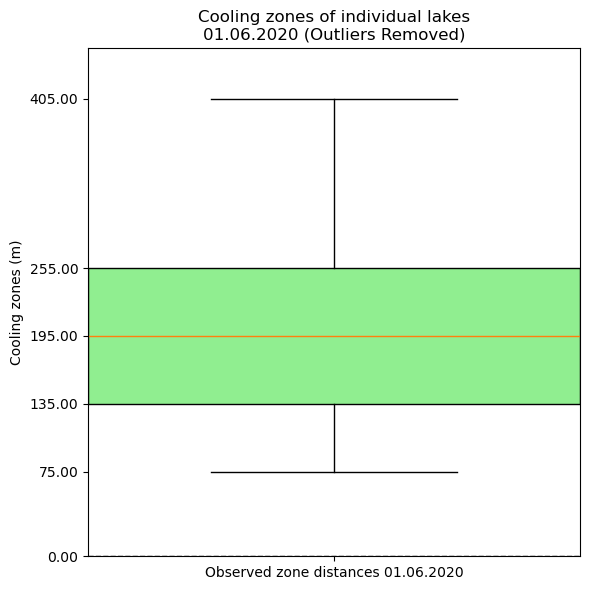

In [13]:
# Box plot over zone effects from individual lakes 
obs_zone_values = lakes_positive["obs_zone"].dropna()

# Compute quartiles
def quartiles_full(res):
    q1, median, q3 = np.percentile(res, [25, 50, 75])
    iqr = q3 - q1
    return {"q1": q1, "median": median, "q3": q3, "iqr": iqr}
stats_obs_zone = quartiles_full(obs_zone_values)

# clip outliers
def clip_whiskers(res, q1, q3):
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return res[(res >= lower) & (res <= upper)]
stats_obs_zone_clip = clip_whiskers(obs_zone_values, stats_obs_zone["q1"], stats_obs_zone["q3"])

# Plot boxplot
plt.figure(figsize=(6,6))
box_data = [stats_obs_zone_clip]
labels = ["Observed zone distances 01.06.2020"]

bplots = plt.boxplot(
    box_data,
    vert=True,
    showfliers=False,
    widths=0.5,
    patch_artist=True,
    tick_labels=labels
)
# Color boxes
colors = ["lightgreen", "lightblue"]
for patch, color in zip(bplots['boxes'], colors):
    patch.set_facecolor(color)
# Draw quartile lines
box_positions = [1, 2]  # x positions of boxes
for pos, stats_spec in zip(box_positions, [stats_obs_zone]):
    # Width for the median line: half the box width
    box_width = 0.5
    half_width = box_width / 2

# zero reference line
plt.axhline(0, color="black", linestyle="--", linewidth=1)

#Y limits and tics
y_min = stats_obs_zone_clip.min()
y_max = stats_obs_zone_clip.max()
plt.xlim(0.75, 1.25)

# Include Q1, median, Q3 of both boxes + zero
y_ticks = sorted(list(set([
    stats_obs_zone['q1'], stats_obs_zone['median'], stats_obs_zone['q3'],
    y_min, y_max, 0
])))
plt.ylim(0, 450) #y_min, #y_max
plt.yticks(y_ticks, [f"{y:.2f}" for y in y_ticks])

# -----------------------------
# 8. Labels and title
# -----------------------------
plt.ylabel("Cooling zones (m)") 
plt.title("Cooling zones of individual lakes\n01.06.2020 (Outliers Removed)")
plt.tight_layout()
plt.savefig("Fig20200601_boxplot_zones.png", dpi=400, bbox_inches="tight")
plt.show()

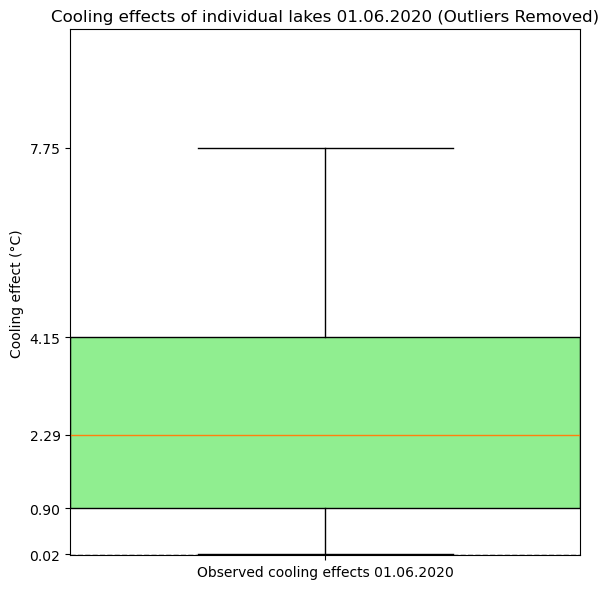

In [14]:
# Box plot over cooling effects from individual lakes
obs_zone_values = lakes_positive["obs_cooldif"].dropna()

# Compute quartiles
def quartiles_full(res):
    q1, median, q3 = np.percentile(res, [25, 50, 75])
    iqr = q3 - q1
    return {"q1": q1, "median": median, "q3": q3, "iqr": iqr}
stats_obs_zone = quartiles_full(obs_zone_values)

# clip outliers
def clip_whiskers(res, q1, q3):
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return res[(res >= lower) & (res <= upper)]
stats_obs_zone_clip = clip_whiskers(obs_zone_values, stats_obs_zone["q1"], stats_obs_zone["q3"])

# Plot boxplot
plt.figure(figsize=(6,6))
box_data = [stats_obs_zone_clip]
labels = ["Observed cooling effects 01.06.2020"]

bplots = plt.boxplot(
    box_data,
    vert=True,
    showfliers=False,
    widths=0.5,
    patch_artist=True, 
    tick_labels=labels
)
# Color boxes
colors = ["lightgreen", "lightblue"]
for patch, color in zip(bplots['boxes'], colors):
    patch.set_facecolor(color)
# Draw quartile lines
box_positions = [1, 2]  # x positions of boxes
for pos, stats_spec in zip(box_positions, [stats_obs_zone]):
    # Width for the median line: half the box width
    box_width = 0.5
    half_width = box_width / 2

# zero reference line
plt.axhline(0, color="black", linestyle="--", linewidth=1)

#Y limits and tics
y_min = stats_obs_zone_clip.min()
y_max = stats_obs_zone_clip.max()
plt.xlim(0.75, 1.25)

# Include Q1, median, Q3 of both boxes + zero
y_ticks = sorted(list(set([
    stats_obs_zone['q1'], stats_obs_zone['median'], stats_obs_zone['q3'],
    y_min, y_max #, 0
])))
plt.ylim(0, 10) #y_min y_max
plt.yticks(y_ticks, [f"{y:.2f}" for y in y_ticks])

# -----------------------------
# 8. Labels and title
# -----------------------------
plt.ylabel("Cooling effect (°C)") 
plt.title("Cooling effects of individual lakes 01.06.2020 (Outliers Removed)")
plt.tight_layout()
plt.savefig("Fig20200601_boxplot_cooling.png", dpi=400, bbox_inches="tight")
plt.show()


In [15]:
# Centroids
centroids = lakes_positive.geometry.centroid
coords = np.array([[p.x, p.y] for p in centroids])

# Compute pairwise distances
dist_matrix = squareform(pdist(coords))

print("Minimum non-zero distance between centroids (meters):", np.min(dist_matrix[dist_matrix>0]))
print("Maximum distance:", np.max(dist_matrix))

Minimum non-zero distance between centroids (meters): 14.316893747583777
Maximum distance: 13268.397934864344


/opt/anaconda3/lib/python3.13/site-packages/scipy/sparse/_data.py:128: RuntimeWarning: divide by zero encountered in power
  return self._with_data(data ** n)


Sum of weights: 132.0
Min neighbors: 78
Mean neighbors: 112.98484848484848
Observed Moran's I: 0.20753013160349365
Permutation p-value: 0.001


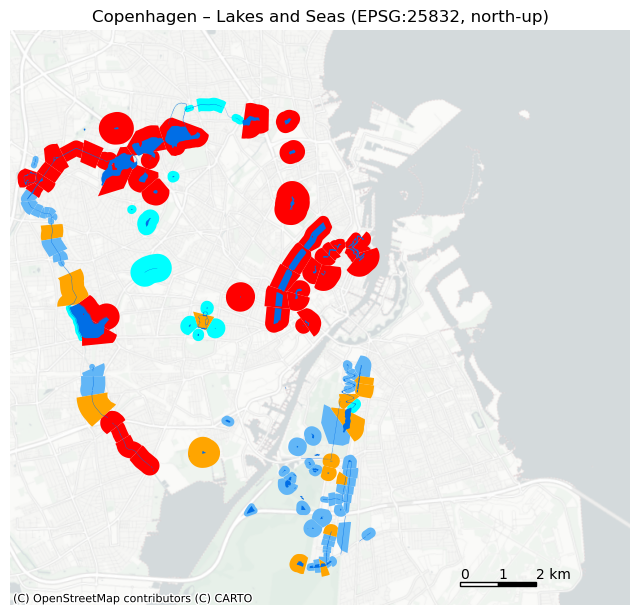

In [16]:
# MORANS I
# Use your actual geometry column to build distance-based weights 
w = DistanceBand.from_dataframe(
    lakes_positive,
    threshold=10000, # 10 km threshold, adjust if needed
    binary=False,
    alpha=-1.0,
    silence_warnings=True,
    geom_col='geometry_buffered_obs'  
)
w.transform = "r"
W = w.full()[0]
# Sanity check
print("Sum of weights:", W.sum())
print("Min neighbors:", min(w.cardinalities.values()))
print("Mean neighbors:", w.mean_neighbors)
if W.sum() == 0:
    raise ValueError("No spatial neighbors found. Increase threshold.")

# function to calculate Moran's I based on x (cooling intensity) and W (weights)  
def moran_I(x, W):
    x = np.asarray(x)
    x = x - x.mean()
    
    den = np.sum(x**2)
    W_sum = W.sum()
    
    if den == 0:
        raise ValueError("Zero variance in variable — Moran's I undefined")
    if W_sum == 0:
        raise ValueError("No spatial neighbors — Moran's I undefined")
    
    n = len(x)
    num = np.sum(W * np.outer(x, x))
    
    return (n / W_sum) * (num / den)

# compute Moran's I based on x (cooling intensity) and W (weights)  
x = lakes_positive["obs_cooldif"].values.astype(float)
I_obs = moran_I(x, W)
print("Observed Moran's I:", I_obs)

# permutation test:   
n_perm = 999
rng = np.random.default_rng(seed=42)
I_perm = np.zeros(n_perm)
for i in range(n_perm):
    x_perm = rng.permutation(x)
    I_perm[i] = moran_I(x_perm, W)
# Two-sided pseudo p-value
p_value = (np.sum(np.abs(I_perm) >= np.abs(I_obs)) + 1) / (n_perm + 1)
print("Permutation p-value:", p_value)

x_std = x - x.mean()
lag_x = W @ x_std
# Add to GeoDataFrame
lakes_positive["x_std"] = x_std
lakes_positive["lag_x"] = lag_x

def moran_quadrant(row):
    if row.x_std > 0 and row.lag_x > 0:
        return "High–High"
    elif row.x_std < 0 and row.lag_x < 0:
        return "Low–Low"
    elif row.x_std > 0 and row.lag_x < 0:
        return "High–Low"
    else:
        return "Low–High"
lakes_positive["moran_quadrant"] = lakes_positive.apply(moran_quadrant, axis=1)

# Define colors for quadrants
quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6", #"blue"
    "High–Low": "orange",
    "Low–High": "cyan"
}

#lakes_positive['geometry_buffered_obs'] = lakes_positive.geometry.buffer(lakes_positive['obs_zone']) #obs_dist
centroids = lakes_positive.geometry.centroid

# Create Voronoi diagram with envelope = union of buffered polygons
vor_obs = voronoi_diagram(
    MultiPoint(list(centroids)),
    envelope=lakes_positive['geometry_buffered_obs'].union_all()  # use union_all() instead of unary_union
)

# Convert Voronoi polygons to a GeoDataFrame
vor_obs_gdf = gpd.GeoDataFrame(geometry=list(vor_obs.geoms), crs=lakes_positive.crs)

# Clip each buffer to its Voronoi polygon
buffers_cut = []
# Loop over each lake buffer
for i, buffer_geom in enumerate(lakes_positive['geometry_buffered_obs']):
    centroid = lakes_positive.geometry.iloc[i].centroid  # lake centroid
    # Find the Voronoi polygon that contains this centroid
    matching_cell = vor_obs_gdf[vor_obs_gdf.geometry.contains(centroid)]
    if not matching_cell.empty:
        buffers_cut.append(buffer_geom.intersection(matching_cell.geometry.iloc[0]))
    else:
        # fallback if something went wrong
        buffers_cut.append(buffer_geom)
        
# Create a GeoDataFrame of clipped buffers
vor_obs_gdf_clipped = gpd.GeoDataFrame({
    'geometry': buffers_cut,
    'id': lakes_positive['id'],
    'moran_quadrant': lakes_positive['moran_quadrant']
}, crs=lakes_positive.crs)

# Remove empty geometries (just in case)
vor_obs_gdf_clipped = vor_obs_gdf_clipped[~vor_obs_gdf_clipped.is_empty].reset_index(drop=True)

# Map over all seas and lakes 
lake_color = "#006EE6"

# Original Copenhagen bbox in WGS84
bbox_wgs84 = box(12.45, 55.61, 12.70, 55.74)

# Project to EPSG:25832
gdf = gpd.GeoDataFrame(geometry=[bbox_wgs84], crs="EPSG:4326").to_crs(epsg=25832)

minx, miny, maxx, maxy = gdf.total_bounds

# Scale bar position (bottom-right)
x_start = maxx - 2000*2 - 500  # shift from edge, in meters
y_start = miny + 500           # shift from bottom, in meters

bar_length = 1000  # 1 km per segment

fig, ax = plt.subplots(figsize=(8, 8))

# Set map extent
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# --- Basemap: Stamen TonerLite, semi-transparent ---
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:25832",  # important: reproject tiles to match axes
    alpha=1.0           # dim basemap, polygons stay vivid
)

# --- Cooling effect
vor_obs_gdf_clipped.plot(
    ax=ax,
    color=vor_obs_gdf_clipped['moran_quadrant'].map(quadrant_colors),
    edgecolor="none"
)

# --- Lakes (full color, north-up) ---
lakes[lakes['details'] == "obs cooling"].plot(
    ax=ax,
    facecolor=lake_color,
    edgecolor="none",
    alpha=1.0,
    zorder=2
    )

# --- Draw striped scale bar: 2 segments (1 km white + 1 km black) ---
scale_colors = ["white", "black"]
for i, color in enumerate(scale_colors):
    rect = patches.Rectangle(
        (x_start + i*bar_length, y_start),  # lower-left corner
        bar_length,                          # width
        100,                                 # height of bar (meters)
        facecolor=color,
        edgecolor="black"
    )
    ax.add_patch(rect)

# Add text labels without repeating "km"
ax.text(x_start, y_start + 120, "0", color="black", fontsize=10, va='bottom')
ax.text(x_start + bar_length, y_start + 120, "1", color="black", fontsize=10, va='bottom')
ax.text(x_start + 2*bar_length, y_start + 120, "2 km", color="black", fontsize=10, va='bottom')

# Optional: remove axes
ax.set_axis_off()
plt.title("Copenhagen – Lakes and Seas (EPSG:25832, north-up)")
plt.show()

fig.savefig(
    "map_cooldif_morans_i_20200601.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)

#Red (HH) → strong cooling zones surrounded by strong cooling neighbors

#Blue (LL) → weak cooling zones surrounded by weak cooling neighbors

#Orange (HL) / Cyan (LH) → spatial outliers (opposite pattern to neighbors)

In [17]:
# Merge only the column of interest
lakes = lakes_positive.merge(
    lakes_positive[['id', 'obs_zone', 'obs_cooldif', 'moran_quadrant']],  # columns to copy
    on='id',                # join on this column
    how='left'              # keep all rows in lakes
)

In [18]:
# CALCULATION OF NEAREST EUCLIDEAN DISTANCE FROM LAKES TO OTHER WATERBODIESAND ADD AS COLUMN
lakes_for_analysis = lakes.copy()

# Nearest lake to lake
dist_matrix = lakes_for_analysis.geometry.apply(
    lambda g: lakes_for_analysis.geometry.distance(g)
)

nearest_shore_dist = (
    dist_matrix
    .replace(0, np.nan)
    .min(axis=1)
)

lakes_for_analysis["nearest_lake_shore_dist"] = nearest_shore_dist
#print(lakes_for_analysis["nearest_lake_shore_dist"])

# Nearest lake to sea 
seas_for_analysis = gpd.read_file("analysis_input_data/seas.shp") # all sea polygons with attribute data
seas_for_analysis = seas_for_analysis[seas_for_analysis.geometry.notna()].copy()

lakes_for_analysis["nearest_sea_dist"] = lakes_for_analysis.geometry.apply(
    lambda g: seas_for_analysis.geometry.distance(g).min()
)

#print(lakes_for_analysis["nearest_sea_dist"])

# Nearest lake to waterbody 
lakes_for_analysis["nearest_waterbody_dist"] = lakes_for_analysis[
    ["nearest_lake_shore_dist", "nearest_sea_dist"]
].min(axis=1)

lakes_for_analysis = lakes_for_analysis[['id', 'nearest_waterbody_dist']]
print(lakes_for_analysis)

lakes = lakes.merge(
    lakes_for_analysis,
    on='id',
    how='left'
)

       id  nearest_waterbody_dist
0    1138              204.618371
1    1140                3.213572
2     517              327.657476
3     516                5.959810
4     199              652.492608
..    ...                     ...
127  1224              293.519858
128  1241              447.221110
129  1234               16.726190
130  1235               16.726190
131  1237              199.499833

[132 rows x 2 columns]


In [19]:
# CALCULATE OTHER VARIABLES AT LAKE LEVEL (NOT BIN DIFFERENCES) AND ADD AS ATTRIBUTES:  

# We have in lakes_positive: 
# 'obs_zone': turning point distance
# 'obs_cooldif': turning point effects
# 'area_ha': lake size 
# 'perimeter': perimeter
# 'nearest_waterbody_dist': nearest distance to waterbody for all lakes 

# We now calculate: 
# 'mean_lst_400m': LST within 30-400m
# 'mean_mndwi_400m': MNDWI within 30-400m
# "mean_ndvi_400m": NDVI within 30-400m
# "imp": imperviousness 2018 within 30-400m
# "lsi": landscape shape index

### Analysis 6B: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
##bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
##bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = lakes['id']

# Create a new column filled with NaNs
lakes["mean_lst_400m"] = np.nan
lakes["mean_mndwi_400m"] = np.nan
lakes["mean_ndvi_400m"] = np.nan
lakes["mean_imp_400m"] = np.nan
lakes["LSI"] = np.nan

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & (lake_dist >= 30) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    raster_mean_lst_400m_vals = lst[base_mask]
    raster_mean_mndwi_400m_vals = mndwi[base_mask]
    raster_mean_ndvi_400m_vals = ndvi[base_mask]
    raster_mean_imp_400m_vals = imp[base_mask]
    
    if raster1_vals.size > 0:
        # Assign ONLY to this lake_id
        lake_row = lakes["id"] == lake_id
        mean_lst   = np.nanmean(lst[base_mask])
        mean_mndwi = np.nanmean(mndwi[base_mask])
        mean_ndvi  = np.nanmean(ndvi[base_mask])
        mean_imp   = np.nanmean(imp[base_mask])
        lakes.loc[lake_row, "mean_lst_400m"]   = mean_lst
        lakes.loc[lake_row, "mean_mndwi_400m"] = mean_mndwi
        lakes.loc[lake_row, "mean_ndvi_400m"]  = mean_ndvi
        lakes.loc[lake_row, "mean_imp_400m"]   = mean_imp
        # LSI (can be computed once, but safe here)
        lakes.loc[lake_row, "LSI"] = (0.25 * lakes.loc[lake_row, "perimeter"]/ np.sqrt(lakes.loc[lake_row, "area_ha"]))

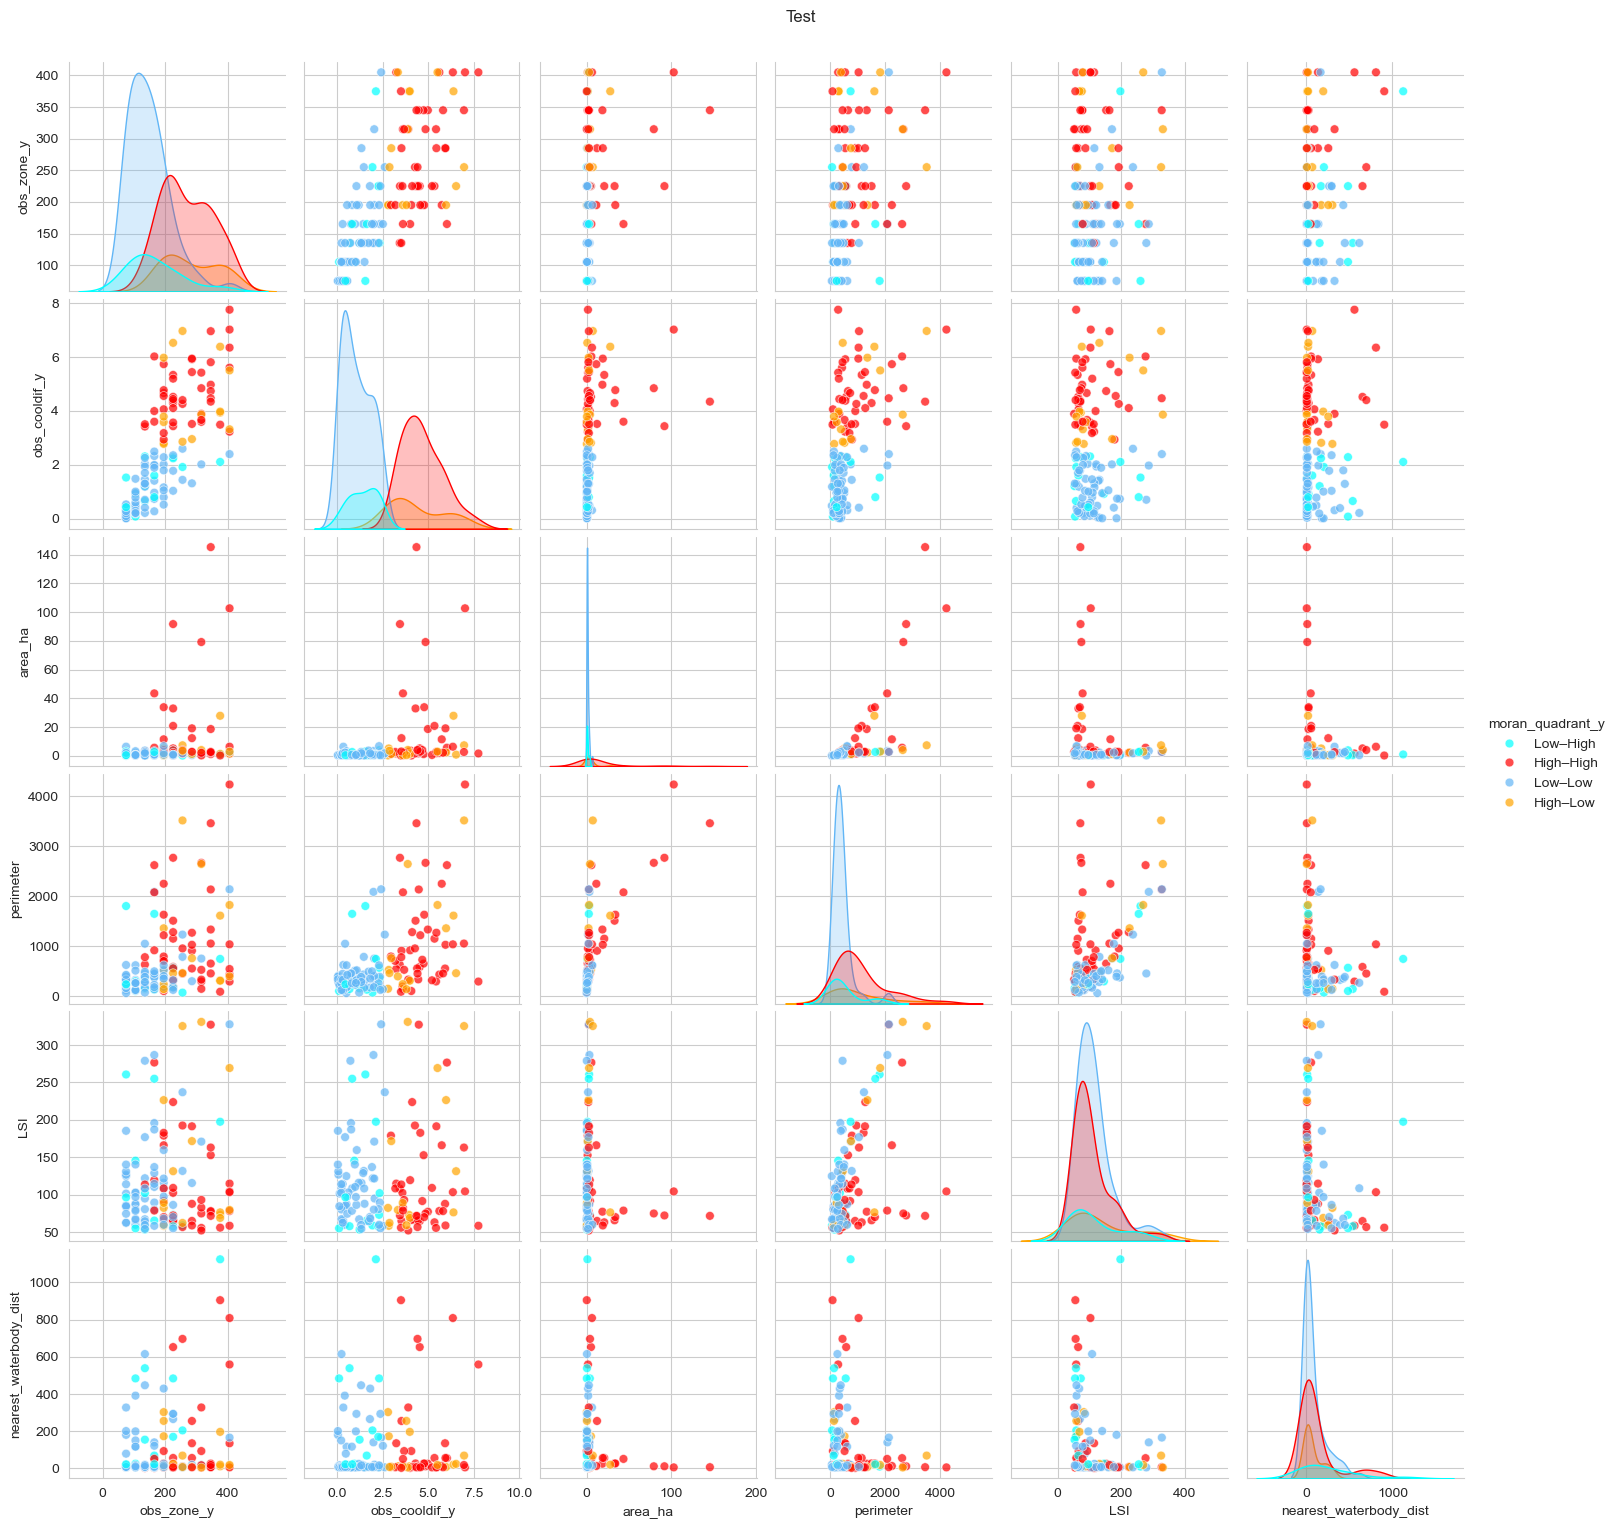

In [20]:
# Pairwise plot of potential components to correlate with observed cooling zone and cooling effect: 
# Lake characteristics 

vars_to_plot = ['obs_zone_y', # 'obs_zone_y'
                'obs_cooldif_y', #'obs_cooldif_y'
                'area_ha',
                'perimeter', 
                'LSI',
                'nearest_waterbody_dist',
                #'mean_lst_400m', 
                #'mean_mndwi_400m', 
                #'mean_ndvi_400m'
               ]

n_pairs = len(vars_to_plot) - 1

quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6",
    "High–Low": "orange",
    "Low–High": "cyan"
}

# Select numeric columns for PCA, drop rows with missing values
df_vars = lakes[vars_to_plot].dropna()

# Extract Moran quadrant for coloring
quadrant_index = lakes.loc[df_vars.index, 'moran_quadrant_y'] #'moran_quadrant_y'
colors = quadrant_index.map(quadrant_colors)


df_vars_to_plot = pd.DataFrame(
    df_vars,
    columns=vars_to_plot,
    index=df_vars.index
)

df_vars_to_plot["moran_quadrant_y"] = quadrant_index.values

#Plot
sns.set_style("whitegrid")

sns.pairplot(
    df_vars_to_plot,
    vars=vars_to_plot,
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Test", y=1.02)
plt.savefig(
    "plot20190606_pairwise_lakedesc.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()



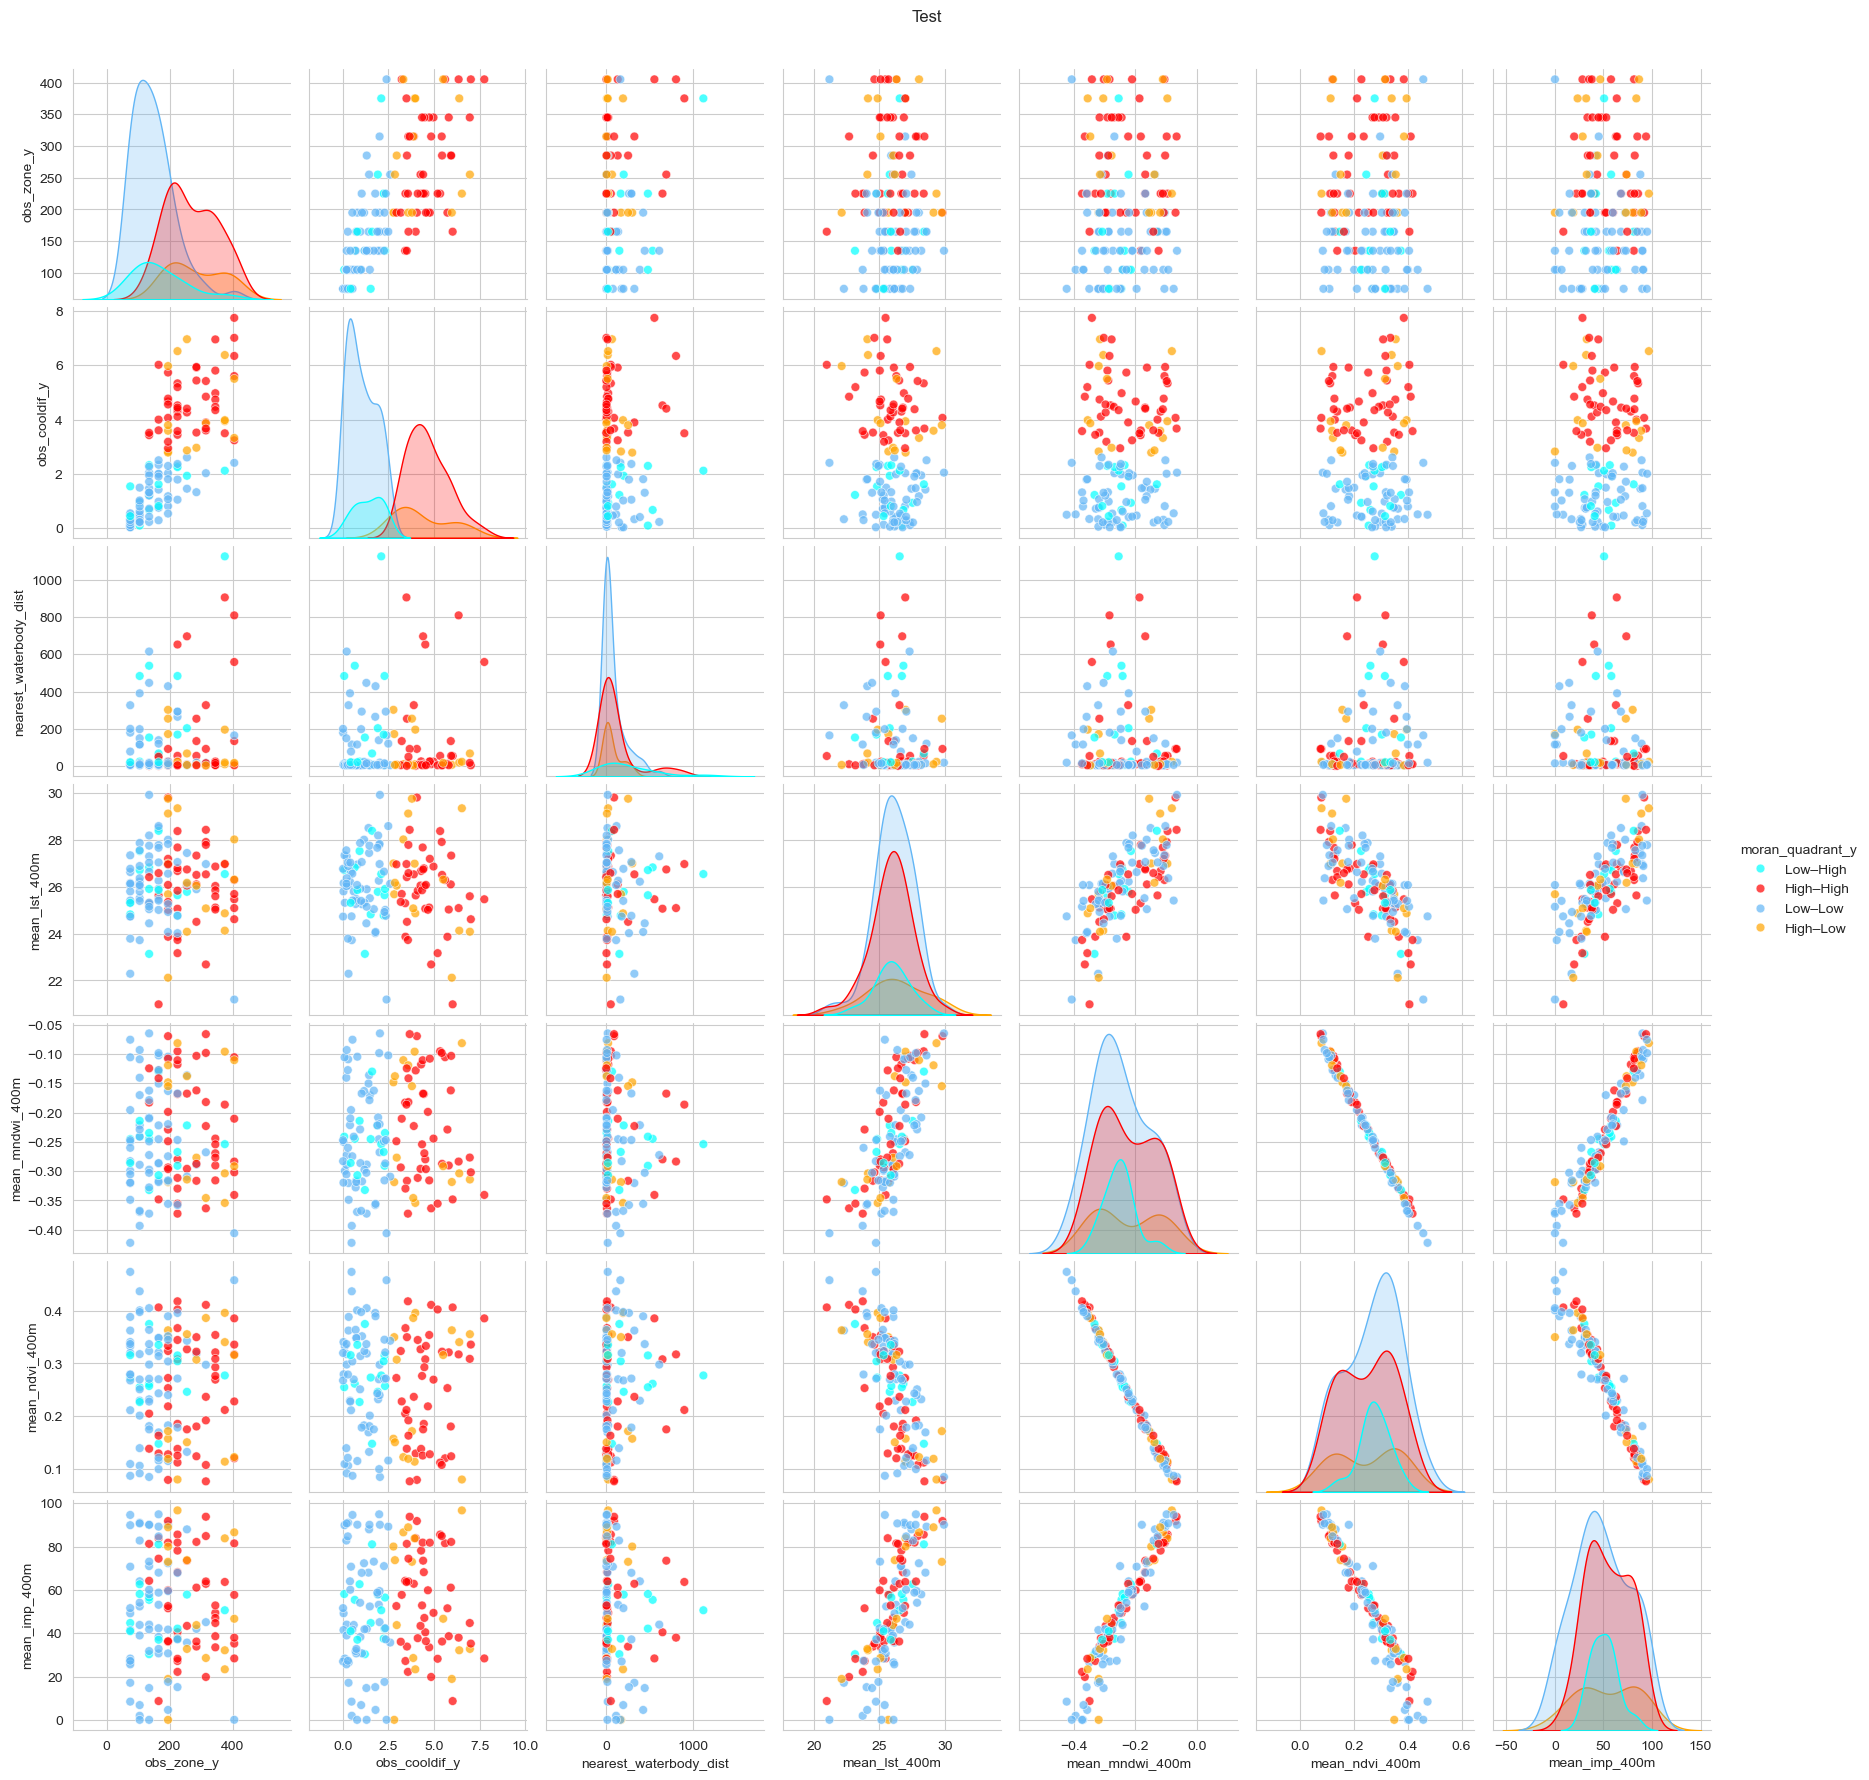

In [21]:
# Pairwise plot of potential components to correlate with observed cooling zone and cooling effect: 
# Background varialbes 

vars_to_plot = ['obs_zone_y',
                'obs_cooldif_y',
                #'area_ha',
                #'perimeter', 
                #'LSI',
                'nearest_waterbody_dist',
                'mean_lst_400m', 
                'mean_mndwi_400m', 
                'mean_ndvi_400m',
                'mean_imp_400m']

n_pairs = len(vars_to_plot) - 1

quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6",
    "High–Low": "orange",
    "Low–High": "cyan"
}

# Select numeric columns for PCA, drop rows with missing values
df_vars = lakes[vars_to_plot].dropna()

# Extract Moran quadrant for coloring
quadrant_index = lakes.loc[df_vars.index, 'moran_quadrant_y']
colors = quadrant_index.map(quadrant_colors)


df_vars_to_plot = pd.DataFrame(
    df_vars,
    columns=vars_to_plot,
    index=df_vars.index
)

df_vars_to_plot["moran_quadrant_y"] = quadrant_index.values

# Plot
sns.set_style("whitegrid")

sns.pairplot(
    df_vars_to_plot,
    vars=vars_to_plot,
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Test", y=1.02)
plt.savefig(
    "plot20180603_pairwise_backgroundvar.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()


Explained variance by PCs: [0.38759873 0.2380789  0.13289405 0.1046391 ]


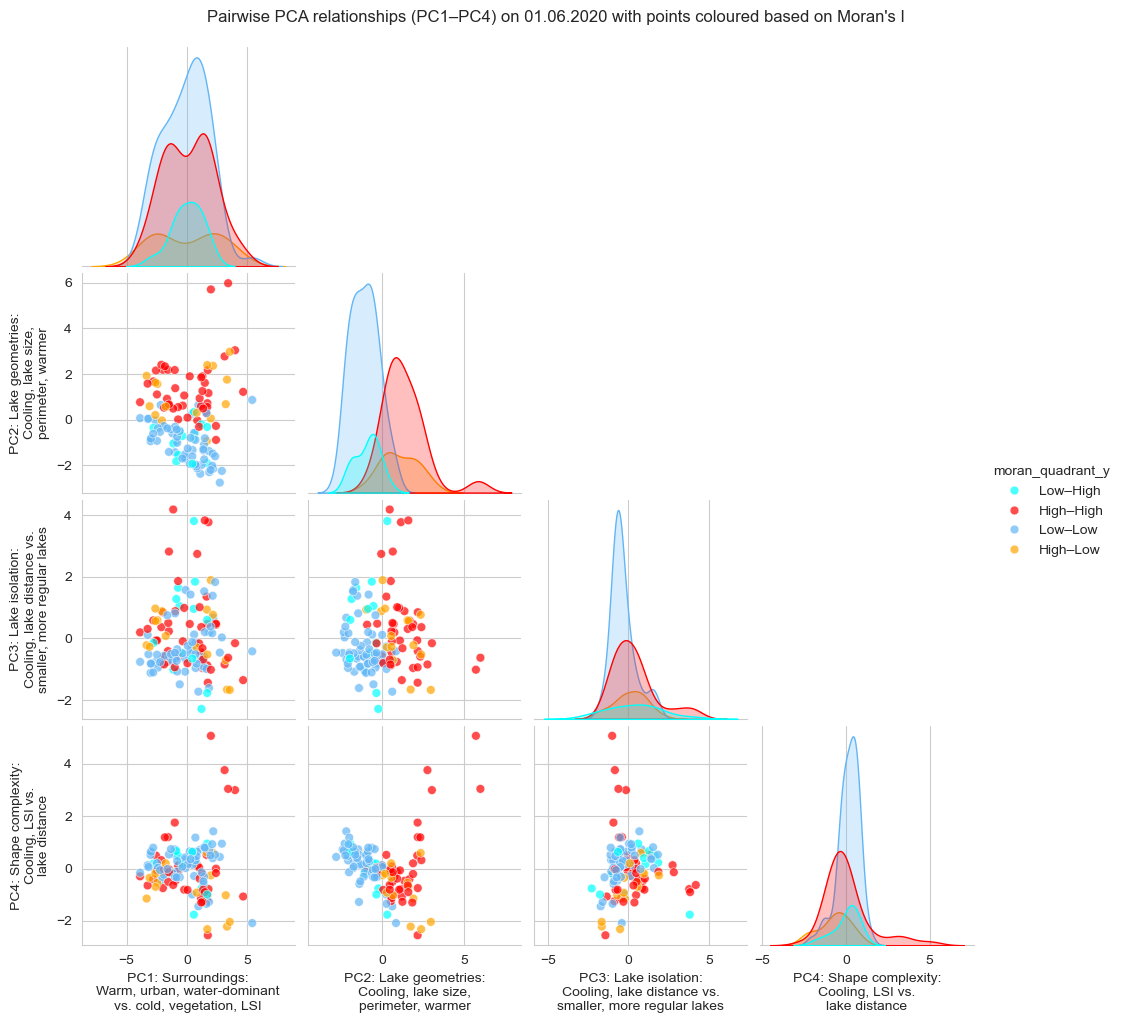

     obs_zone_y  obs_cooldif_y   area_ha  perimeter       LSI  \
PC1    0.081551       0.072154  0.122761   0.249142  0.225934   
PC2    0.472783       0.530569  0.407404   0.472398  0.100226   
PC3    0.386420       0.217419 -0.092701  -0.281577 -0.427848   
PC4   -0.278084      -0.197754  0.668797   0.083322 -0.637775   

     nearest_waterbody_dist  mean_lst_400m  mean_mndwi_400m  mean_ndvi_400m  \
PC1                0.029522      -0.424231        -0.476565        0.480873   
PC2               -0.065159       0.045189         0.174215       -0.161031   
PC3                0.718941      -0.023251        -0.062900        0.062667   
PC4               -0.061677      -0.128878        -0.005405        0.002267   

     mean_imp_400m  
PC1      -0.469850  
PC2       0.182262  
PC3      -0.084705  
PC4      -0.046103  


In [22]:
# Principle components analysis 

vars_to_plot = [
    'obs_zone_y', #justified
    'obs_cooldif_y', #justified
    'area_ha', #justified
    'perimeter', #justified
    'LSI', # split pattern
    'nearest_waterbody_dist', #justified
    'mean_lst_400m', #justified
    'mean_mndwi_400m', 
    'mean_ndvi_400m',
    'mean_imp_400m' #,
    #'herbm2_400m',
    #'forestm2_400m'
]

quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6",
    "High–Low": "orange",
    "Low–High": "cyan"
}

# -------------------------
# PREPARE DATA
# -------------------------

# Select numeric columns for PCA, drop rows with missing values
df_pca = lakes[vars_to_plot].dropna()

# Extract Moran quadrant for coloring
quadrant = lakes.loc[df_pca.index, 'moran_quadrant_y']
colors = quadrant.map(quadrant_colors)

# Standardize the data
X_scaled = StandardScaler().fit_transform(df_pca)

# -------------------------
# RUN PCA
# -------------------------

pca = PCA(n_components=4)  # decides number of principal components
X_pca = pca.fit_transform(X_scaled)

print("Explained variance by PCs:", pca.explained_variance_ratio_)

# -------------------------
# PLOT RESULTS
# -------------------------
# Create PCA score DataFrame
df_scores = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2", "PC3", "PC4"],
    index=df_pca.index
)

df_scores["moran_quadrant_y"] = quadrant.values

# Example: custom PC labels
custom_labels = {
    "PC1": "PC1: Surroundings:\nWarm, urban, water-dominant\nvs. cold, vegetation, LSI",
    "PC2": "PC2: Lake geometries:\nCooling, lake size,\nperimeter, warmer",
    "PC3": "PC3: Lake isolation:\nCooling, lake distance vs.\nsmaller, more regular lakes",
    "PC4": "PC4: Shape complexity:\nCooling, LSI vs.\nlake distance"
}

# Make a temporary copy of df_scores with renamed columns
df_plot = df_scores.rename(columns=custom_labels)

# -------------------------
# PAIRPLOT
# -------------------------

plt.close("all")
sns.set_style("whitegrid")

sns.pairplot(
    df_plot,
    vars=list(custom_labels.values()), #["PC1", "PC2", "PC3", "PC4"],
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    corner=True,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Pairwise PCA relationships (PC1–PC4) on 01.06.2020 with points coloured based on Moran's I", y=1.02)
plt.savefig(
    "20200601pca_result_graph.png",  # file name
    dpi=400,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()

loadings_all = pd.DataFrame(
    pca.components_,
    columns=vars_to_plot,  # <-- make sure this is the same list used in PCA
    index=[f'PC{i+1}' for i in range(4)]  # match n_components=4
)

print(loadings_all.loc[["PC1", "PC2", "PC3", "PC4"]])    


Explained variance by PCs: [0.37039256 0.2031012  0.15254212 0.14208217]


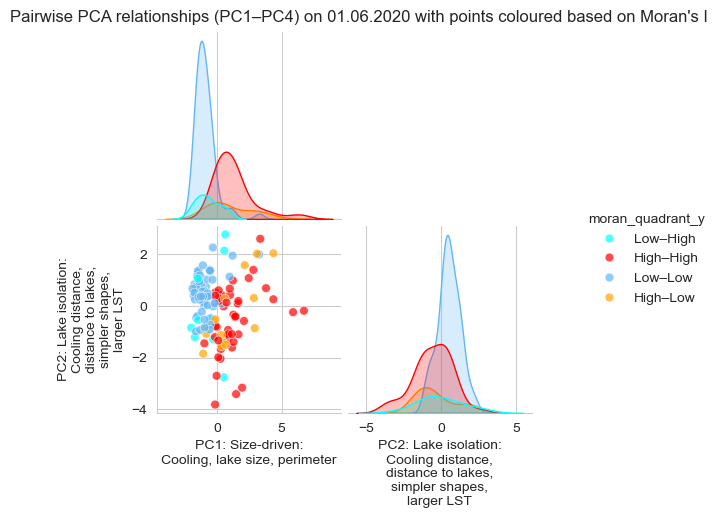

     obs_zone_y  obs_cooldif_y   area_ha  perimeter       LSI  \
PC1    0.424791       0.472925  0.410686   0.557316  0.242667   
PC2   -0.453493      -0.336316 -0.019656   0.246886  0.512319   
PC3   -0.221253      -0.083386  0.621595   0.093209 -0.535417   
PC4    0.217755       0.266533 -0.289298  -0.062664  0.281453   

     nearest_waterbody_dist  mean_lst_400m  
PC1               -0.048116      -0.235431  
PC2               -0.510412      -0.311296  
PC3               -0.432298       0.274724  
PC4               -0.514763       0.670617  


In [23]:
# Principle components analysis 

vars_to_plot = [
    'obs_zone_y', #justified
    'obs_cooldif_y', #justified
    'area_ha', #justified
    'perimeter', #justified
    'LSI', # split pattern
    'nearest_waterbody_dist', #justified
    'mean_lst_400m', #justified
    #'mean_mndwi_400m', 
    #'mean_ndvi_400m',
    #'mean_imp_400m' #,
    #'herbm2_400m',
    #'forestm2_400m'
]

quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6",
    "High–Low": "orange",
    "Low–High": "cyan"
}

# -------------------------
# PREPARE DATA
# -------------------------

# Select numeric columns for PCA, drop rows with missing values
df_pca = lakes[vars_to_plot].dropna()

# Extract Moran quadrant for coloring
quadrant = lakes.loc[df_pca.index, 'moran_quadrant_y']
colors = quadrant.map(quadrant_colors)

# Standardize the data
X_scaled = StandardScaler().fit_transform(df_pca)

# -------------------------
# RUN PCA
# -------------------------

pca = PCA(n_components=4)  # decides number of principal components
X_pca = pca.fit_transform(X_scaled)

print("Explained variance by PCs:", pca.explained_variance_ratio_)

# -------------------------
# PLOT RESULTS
# -------------------------
# Create PCA score DataFrame
df_scores = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2", "PC3", "PC4"],
    index=df_pca.index
)

df_scores["moran_quadrant_y"] = quadrant.values

# Example: custom PC labels
custom_labels = {
    "PC1": "PC1: Size-driven:\nCooling, lake size, perimeter",
    "PC2": "PC2: Lake isolation:\nCooling distance,\ndistance to lakes,\nsimpler shapes,\nlarger LST" #,
    #"PC3": "PC3: Lake morphology\nindependent from cooling",
    #"PC4": "PC4: Thermal context\nindependent from cooling"
}

# Make a temporary copy of df_scores with renamed columns
df_plot = df_scores.rename(columns=custom_labels)

# -------------------------
# PAIRPLOT
# -------------------------

plt.close("all")
sns.set_style("whitegrid")

sns.pairplot(
    df_plot,
    vars=list(custom_labels.values()), #["PC1", "PC2", "PC3", "PC4"],
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    corner=True,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Pairwise PCA relationships (PC1–PC4) on 01.06.2020 with points coloured based on Moran's I", y=1.02)
plt.savefig(
    "20200601pca_result_graph_small.png",  # file name
    dpi=400,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()

loadings_all = pd.DataFrame(
    pca.components_,
    columns=vars_to_plot,  # <-- make sure this is the same list used in PCA
    index=[f'PC{i+1}' for i in range(4)]  # match n_components=4
)

print(loadings_all.loc[["PC1", "PC2", "PC3", "PC4"]])    

In [24]:
import numpy as np
import statsmodels.api as sm

X = np.column_stack([
    np.log(lakes["area_ha"]),
    #lakes["perimeter"],
    #lakes["LSI"],
    #lakes["mean_lst_400m"],
    #lakes["nearest_waterbody_dist"],
    lakes['obs_zone_y']
])

X = sm.add_constant(X)

y = lakes["obs_cooldif_y"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          obs_cooldif_y   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     102.7
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           2.09e-27
Time:                        00:59:57   Log-Likelihood:                -215.29
No. Observations:                 132   AIC:                             436.6
Df Residuals:                     129   BIC:                             445.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0715      0.271      0.264      0.7

In [25]:
from scipy.stats import linregress
# Get r2 values for individual parameters describing cooling effect
# Get r2 values for individual parameters describing cooling effect
lakes_subset = lakes[lakes['obs_cooldif_y'].notna()]
y = lakes_subset['obs_cooldif_y']

x_vars = [
    'obs_zone_y',
    'area_ha',
    'perimeter',
    'LSI',
    'nearest_waterbody_dist',
    'mean_lst_400m',
    'mean_mndwi_400m',
    'mean_ndvi_400m',
    'mean_imp_400m'
]

results = []

for x in x_vars:
    df = lakes_subset[[x, 'obs_cooldif_y']].dropna()
    res = linregress(df[x], df['obs_cooldif_y'])

    results.append({
        'variable': x,
        'r2': res.rvalue**2,
        'slope': res.slope,
        'p_value': res.pvalue
    })

r2_table = pd.DataFrame(results).sort_values('r2', ascending=False)
print(r2_table)  # replace with your y attribute # 'obs_zone_y'

                 variable        r2     slope       p_value
0              obs_zone_y  0.522105  0.014981  1.376846e-22
2               perimeter  0.249445  0.001296  1.086658e-09
1                 area_ha  0.092555  0.031720  3.903568e-04
3                     LSI  0.009078  0.002861  2.771456e-01
5           mean_lst_400m  0.007661 -0.108713  3.182972e-01
6         mean_mndwi_400m  0.003882  1.390298  4.778804e-01
8           mean_imp_400m  0.002954  0.004257  5.359506e-01
7          mean_ndvi_400m  0.001258 -0.704646  6.863705e-01
4  nearest_waterbody_dist  0.000218  0.000148  8.665797e-01


In [26]:
# Get r2 values for individual parameters describing cooling effect
# Get r2 values for individual parameters describing cooling effect
lakes_subset = lakes[lakes['obs_cooldif_y'].notna()]
y = lakes_subset['obs_cooldif_y']

x_vars = [
    'obs_zone_y',
    'area_ha',
    'perimeter',
    'LSI',
    'nearest_waterbody_dist',
    'mean_lst_400m',
    'mean_mndwi_400m',
    'mean_ndvi_400m',
    'mean_imp_400m'
]

results = []

for x in x_vars:
    df = lakes_subset[[x, 'obs_cooldif_y']].dropna()
    res = linregress(df[x], df['obs_cooldif_y'])

    results.append({
        'variable': x,
        'r2': res.rvalue**2,
        'slope': res.slope,
        'p_value': res.pvalue
    })

r2_table = pd.DataFrame(results).sort_values('r2', ascending=False)
print(r2_table)  # replace with your y attribute # 'obs_zone_y'


                 variable        r2     slope       p_value
0              obs_zone_y  0.522105  0.014981  1.376846e-22
2               perimeter  0.249445  0.001296  1.086658e-09
1                 area_ha  0.092555  0.031720  3.903568e-04
3                     LSI  0.009078  0.002861  2.771456e-01
5           mean_lst_400m  0.007661 -0.108713  3.182972e-01
6         mean_mndwi_400m  0.003882  1.390298  4.778804e-01
8           mean_imp_400m  0.002954  0.004257  5.359506e-01
7          mean_ndvi_400m  0.001258 -0.704646  6.863705e-01
4  nearest_waterbody_dist  0.000218  0.000148  8.665797e-01


In [111]:
print("mean distance bin (not the same as the one average turning point trend across all lakes applied as turning point in the code):")
print(np.nanmean(lakes['obs_zone_y']))
print("mean cooling effect (not the same as the average cooling effect trend across all lakes applied as cooling effect in the code):")
print(np.nanmean(lakes['obs_cooldif_y']))
print("mean LST from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_lst_400m']))
print("mean MNDWI from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_mndwi_400m']))
print("mean ndvi from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_ndvi_400m']))
print("mean imp from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_imp_400m']))


mean distance bin (not the same as the one average turning point trend across all lakes applied as turning point in the code):
205.22727272727272
mean cooling effect (not the same as the average cooling effect trend across all lakes applied as cooling effect in the code):
2.670402016897161
mean LST from 0-400m averaged across all lakes:
26.040418384291087
mean MNDWI from 0-400m averaged across all lakes:
-0.23687298412107274
mean ndvi from 0-400m averaged across all lakes:
0.26131514335553446
mean imp from 0-400m averaged across all lakes:
51.39152149728174


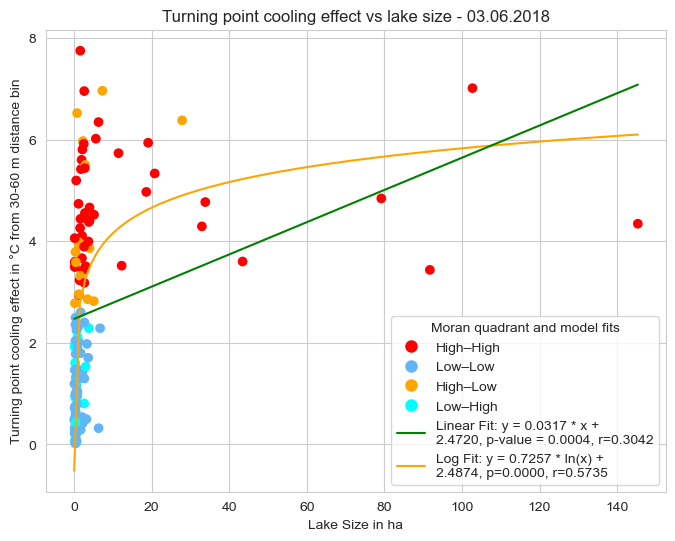

P-value for the logarithmic fit: 0.0000
R-value for the logarithmic fit: 0.5735
The logarithmic fit formula is: y = 0.7257 * ln(x) + 2.4874
P-value for the linear fit: 0.0004
R-value for the linear fit: 0.3042
The linear fit formula is: y = 0.0317 * x + 2.4720


In [27]:
### Graph 4: Analysis: Cooling effect from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
lake_sizes = []
lake_quadrants = []

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0:
        mean_LST_increases.append(turn_mean_lst_values)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Convert lists to numpy arrays
lake_sizes = np.array(lake_sizes)
mean_LST_increases = np.array(mean_LST_increases)
#print(len(lake_sizes))
#print(len(mean_LST_increases))

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(lake_sizes, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(lake_sizes, mean_LST_increases, c=point_colors, marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
line_log, = plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}, r={r_value_log:.4f}")

# Plot the fitted linear trend
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}, r={r_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Lake Size in ha")
plt.ylabel("Turning point cooling effect in °C from 30-60 m distance bin")
plt.title("Turning point cooling effect vs lake size - 03.06.2018")

# Display grid and legend
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20200601_turningPointCool30VSlakeSize.png", dpi=400, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"R-value for the linear fit: {r_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")

In [28]:
#Threshold value of efficiency is defined to be y=x where x is lake size and y is cooling modelled by lake size

# if lake size = 2.465 ha
print((0.7257*np.log(3.368)+2.4874)/3.368)
print((0.7257*np.log(3.369)+2.4874)/3.369)



1.0001874608797579
0.9999545281634902


In [29]:
print("mean distance bin (not the same as the one average turning point trend across all lakes applied as turning point in the code):")
print(np.nanmean(lakes['obs_zone_y']))
print("mean cooling effect (not the same as the average cooling effect trend across all lakes applied as cooling effect in the code):")
print(np.nanmean(lakes['obs_cooldif_y']))
print("mean LST from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_lst_400m']))
print("mean MNDWI from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_mndwi_400m']))
print("mean ndvi from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_ndvi_400m']))
print("mean imp from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_imp_400m']))
print("mean lake size:")
print(np.nanmean(lakes['area_ha']))
print("mean lake perimeter:")
print(np.nanmean(lakes['perimeter']))
print("mean LSI:")
print(np.nanmean(lakes['LSI']))
print("mean nearest waterbody distance:")
print(np.nanmean(lakes['nearest_waterbody_dist']))


# Definition of turning point that I use: 
# Averages delta-LST in each distance bin across all lakes - find slope of the average curve 
# Answers: At what distance does the average cooling effect across all lakes stop increasing?
# One turning point for the entire population
# Smooth (noise is reduced by averaging)
# Dominated by large / strong lakes
# Sensitive to binning and weighting
# This is a population-level physical signal

# Alternative method: 
# Compute individual turning points for each lake and average them 
# What is the average distance at which individual lakes reach their maximum cooling effect?
# Each lake counts equally 
# Very sensitive to noise in individual profiles
# Small lakes and weak signals matter just as much
# Distribution can be skewed or multi-modal

mean distance bin (not the same as the one average turning point trend across all lakes applied as turning point in the code):
205.22727272727272
mean cooling effect (not the same as the average cooling effect trend across all lakes applied as cooling effect in the code):
2.670402016897161
mean LST from 0-400m averaged across all lakes:
26.040418384291087
mean MNDWI from 0-400m averaged across all lakes:
-0.23687298412107274
mean ndvi from 0-400m averaged across all lakes:
0.26131514335553446
mean imp from 0-400m averaged across all lakes:
51.39152149728174
mean lake size:
6.25443802134986
mean lake perimeter:
714.0909090909091
mean LSI:
115.52884741563558
mean nearest waterbody distance:
110.9194099756117
